# Procedures
1. Gaussian Filter
1. Threshholding
1. Enhance Contrast
    1. Histogram Equalization
    2. Adaptive Histogram Equalization(adaptive)
    3. Contrast Limited Adaptive Histogram Equalization(limited adaptive) (CLAHE)
1. Noise Reduction
1. HOG
1. LBP
1. Algorithms
    1. SVM
    2. CNN
    3. VGG-16
    4. RESNET
1. Evealuation
    1. Classification Accuracy
    2. Logarithmic Loss
    3. Confussion Matrix
    4. Area Under Curve
    5. F1 Score
    6. Mean Absolute Error
    7. Mean Square Error

### Necessary Imports

In [142]:
import json
from pathlib import Path
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage import exposure
from skimage.filters import gaussian
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
from skimage.feature import hog, local_binary_pattern
import timeit
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
from functools import wraps


### Necessary Configs

In [143]:
with open('config.json') as file:
    config = json.load(file)
np.random.seed(42)


### Necessary Paths
📦feature-extraction-classification <br>
 ┣ 📂datasets <br>
 ┃ ┣ 📂label1 <br>
 ┃ ┃ ┗ 📜image <br>
 ┃ ┣ 📂label2 <br>
 ┃ ┃ ┗ 📜image <br>
 ┃ ┗ 📂label3 <br>
 ┃  &nbsp; ┗ 📜image <br>
 ┣ 📜config.json <br>
 ┗ 📜main.ipynb

In [144]:
ds_path = join(Path('__file__').parent.absolute(), 'datasets')

### Decorators
- `get_time`
<p>
    It's a decorator that gives the execution time of any function.
</p>

In [145]:
def get_time(func):
    @wraps(func)
    def __(**kwargs):
        start_time = timeit.default_timer()
        _ = func(**kwargs)
        print(f'{func.__name__}() takes {timeit.default_timer() - start_time}sec')
        return _
    return __
def descriptor_info(func):
    @wraps(func)
    def __(**kwargs):
        _ = func(**kwargs)
        def _info(merged_data):
            suptitle = 'histogram of various color channels of ' + merged_data[0, 1]
            imgs_title=['original', 'hog']
            cmp_suptitle ='comparing original, hog descriptor on ' + merged_data[0, 1]
            descriptor_img = merged_data[0, 2]
            if merged_data[0, 2] is None:
                imgs_title=['original', 'lbp']
                cmp_suptitle ='comparing original, lbp descriptor on ' + merged_data[0, 1]
                descriptor_img = merged_data[0, 0]
            show_hist(merged_data[0, -1], suptitle=suptitle)
            compare_img(merged_data[0, -1], descriptor_img, imgs_title=imgs_title, suptitle=cmp_suptitle)
        print('\n\nSample Train Info: \n')
        _info(kwargs['train_datasets'])
        print('\n\nSample Test Info: \n')
        _info(kwargs['test_datasets'])
        return _
    return __
def train_test_split(func):
    @wraps(func)
    def __(**kwargs):
        train, test = train_test(merge_feat_lab(kwargs['descriptor']), test_size=kwargs['test_size'])
        test_size = kwargs['test_size'] * 100
        print(f'test size percentage = {test_size}%', f'train size = {len(train)}', f'test size = {len(test)}', sep='\n')
        kwargs['train_datasets'], kwargs['test_datasets'] = train, test
        kwargs['x_train'], kwargs['y_train'], kwargs['x_test'], kwargs['y_test'] = [train[i, 0] for i in range(len(train))], [train[i, 1] for i in range(len(train))], [test[i, 0] for i in range(len(test))], [test[i, 0] for i in range(len(test))]
        return func(**kwargs)
    return __
def gridSearchCV(func):
    @wraps(func)
    def __(**kwargs):
        kwargs['grid_search'] = GridSearchCV(estimator=kwargs['clf'], param_grid=kwargs['clf_param'], n_jobs = config['gridSearchCV']['n_jobs'], cv = config['gridSearchCV']['cv'], refit = config['gridSearchCV']['refit'], verbose = config['gridSearchCV']['verbose'])
        return func(**kwargs)
    return __


### Necessary Functions
- `show_img`
<p>
    parameters: 
    <ul>
        <li><i>img: fname | BinaryIO</i></li>
        <li><i>title: 'Image' | str</i></li>
        <li><i>
            cmap_type: None | str <br>
            It defines color map, None represents rgb by default. It takes values like Greys etc.
        </i></li>
    </ul>
</p>
- `show_hist`
<p>
    parameters: 
    <ul>
        <li><i>img: fname | BinaryIO</i></li>
        <li><i>color: 'all' | str</i></li>
        <li><i>bins: 256 | number</i></li>
        <li><i>suptitle: 'histogram of various color channels' | str</i></li>
    </ul>
</p>
- `compare_img`
<p>
    parameters: 
    <ul>
        <li><i>
            *args: fname | BinaryIO<br>
            It takes iterable of fname or BinaryIO object.
        </i></li>
        <li><i>
            imgs_title: str<br>
            It takes iterable of str.
        </i></li>
        <li><i>suptitle: 'comparing original and other image' | str</i></li>
        <li><i>
            cmap: None | str <br>
            It defines color map, None represents rgb by default. It takes values like Greys etc.
        </i></li>
        <li><i>
            max_col: 5 | number <br>
            It defines maximumu column of subplot in a single row.
        </i></li>
    </ul>
</p>
- `load_img`
<p>
    returns: 
    <i>
        It yields the ndarray of image object.
    </i>
</p>
- `read_dataset`
<p>
    parameters: 
    <ul>
        <li><i>
            callback: 'function'
        </i></li>
    </ul>
</p>
<p>
    returns: 
    <ul>
        <li><i>It yields the ndarray of image object.</i></li>
        <li><i>
    Or by default this function yields image object but by callback property it can do customize task inside datasets folder.
    </i></li>
    </ul>
</p>
- `collect_labels`
<p>
    returns: 
    <i>
        It yields the name of various labels or names of folder inside datasets folder.
    </i>
</p>
- `merge_feat_lab`
<p>
    parameters: 
    <ul>
        <li><i>
            feat_extract_algo: None | lbp_f
        </i></li>
    </ul>
</p>
<p>
    returns: 
    <ul>
        <li><i>ndarray of (feature: HOG descripter for the image | LBP Image, labels: str, img_view: A visualization of HOG image | None, img: fname | BinaryIO)</i></li>
    </ul>
</p>

> *`None` means it takes `hog_f` as default parameter, or it can take `lbp_f` as parameter.*


In [146]:
rgb2gray = lambda original: color.rgb2gray(original)
rgb = lambda original: color.gray2rgb(original)
read = lambda path: plt.imread(path)
img_red = lambda img: img[:, :, 0]
img_green = lambda img: img[:, :, 1]
img_blue = lambda img: img[:, :, 2]
size = lambda img: img.size
shape = lambda img: img.shape
img_flp_v = lambda img: np.flipud(img)
img_flip_h = lambda img: np.fliplr(img)
gaussian_filtr = lambda img: gaussian(img, multichannel=True)
img_hist_eq = lambda img: exposure.equalize_hist(img)
img_clahe = lambda img: exposure.equalize_adapthist(img, clip_limit=0.03)
img_denoise_tv = lambda img: denoise_tv_chambolle(img, multichannel=True)
img_denoise_bilateral = lambda img: denoise_bilateral(img, multichannel=True)
def show_img(img, title='Image', cmap_type = None):
    plt.imshow(img, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()
def show_hist(img, color='all', bins=256, suptitle='histogram of various color channels'):
    func_map = [img_red, img_green, img_blue]
    col_map = ['red', 'green', 'blue']
    def make_plt(func, title, color):
        plt.hist(func(img).flatten(), bins=bins, color=color)
        plt.title(title)
    if color == 'all':
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            make_plt(func_map[i], col_map[i] + ' channel', col_map[i])
    if color == 'r':
        make_plt(func_map[0], col_map[i] + ' channel', col_map[i])
    if color == 'g':
        make_plt(func_map[1], col_map[i] + ' channel', col_map[i])
    if color == 'b':
        make_plt(func_map[2], col_map[i] + ' channel', col_map[i])
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()
def compare_img(*args, imgs_title, suptitle='comparing original and other image', cmap=None, max_col = 5):
    max_col = max_col if len(args) >= max_col else len(args)
    row_counter = len(args) // max_col if len(args) % max_col == 0 else len(args) // max_col + 1 
    for i in range(len(args)):
        plt.subplot(row_counter, max_col, i + 1)
        plt.imshow(args[i], cmap=cmap)
        plt.title(imgs_title[i])
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(suptitle)
    plt.show()
def load_img():
    yield from read_dataset()
def read_dataset(callback = None):
    for file in listdir(ds_path):
        img_path = join(ds_path, file)
        if isfile(img_path):
            if callback: yield callback(file)
            else: yield read(img_path)
        else: 
            for _file in listdir(join(ds_path, file)):
                if callback: yield callback(file)
                else:
                    img_path = join(ds_path, file, _file)
                    if isfile(img_path): yield read(img_path)            
def collect_labels():
    yield from read_dataset(lambda file: file)
def merge_feat_lab(feat_extract_algo = None):
    feat_extract_algo = lbp_f if feat_extract_algo else hog_f
    def get_img():
        labels = list(collect_labels())
        for index, img in enumerate(load_img()):
            img = resize(img, tuple(config['datasets']['img_shape']), anti_aliasing=True)
            if feat_extract_algo == lbp_f: feature, img_view = lbp_f(img), None
            else: feature, img_view = hog_f(img) 
            yield (feature, labels[index], img_view, img)
    merged_feat_lab = np.array(list(get_img()), dtype=object)
    np.random.shuffle(merged_feat_lab)
    return merged_feat_lab
def train_test(data, test_size = 0.25):
    test_size = int(test_size * len(data))
    return data[test_size:], data[: test_size]


### Feature Extraction Algorithms
- `hog_f`
<p>
    parameters: 
    <ul>
        <li><i>img: fname | BinaryIO</i></li>
    </ul>
</p>
<p>
    returns: 
    <ul>
        <li><i>HOG descripter for the image: ndarray</i></li>
        <li><i>A visualization of HOG image: ndarray</i></li>
    </ul>
</p>

> *for returning both of the values, make sure `feature_vector` and `visualize` set to `True`*

- `lbp_f`
<p>
    parameters: 
    <ul>
        <li><i>img: fname | BinaryIO</i></li>
    </ul>
</p>
<p>
    returns: 
    <ul>
        <li><i>LBP Image: ndarray</i></li>
    </ul>
</p>

In [147]:
hog_f = lambda img: hog(img, orientations=config['hog']['orientations'], pixels_per_cell=tuple(config['hog']['pixels_per_cell']), cells_per_block=tuple(config['hog']['cells_per_block']), block_norm=config['hog']['block_norm'], visualize=config['hog']['visualize'], transform_sqrt=config['hog']['transform_sqrt'], feature_vector=config['hog']['feature_vector'], multichannel=config['hog']['multichannel'])

lbp_f = lambda img: local_binary_pattern(rgb2gray(img), P=config['lbp']['P'], R=config['lbp']['R'], method=config['lbp']['method'])

### Evealuation Techniques

### Working Pipeline

test size percentage = 25.0%
train size = 3
test size = 1
context_manager() takes 3.4799995773937553e-06sec


Sample Train Info: 



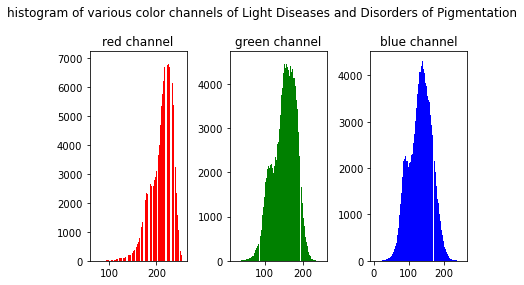

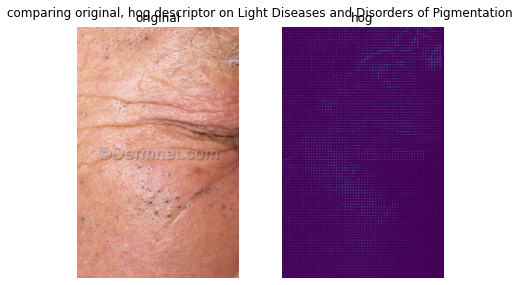



Sample Test Info: 



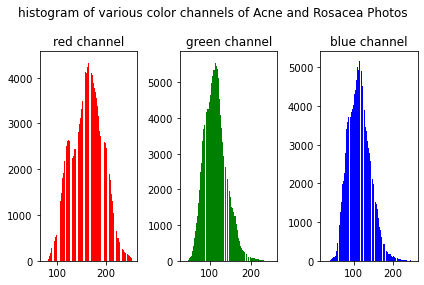

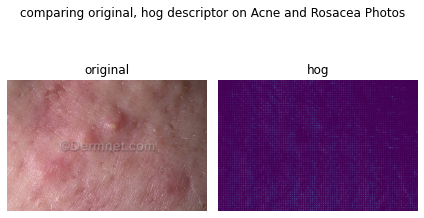

In [148]:
@train_test_split
@descriptor_info
@get_time
def context_manager(**kwargs): pass
context_manager(descriptor = None, test_size = 0.25)